Comparing PCPCA and CPCA Using Silhouette Score

In [1]:
# Required Libraries
# Need to install "openpyxl" through pip to read xlsx data (Although not displayed here)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pcpca import PCPCA, CPCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Data processing for mouse protein
DATA_PATH = "C:/Users/92503/Desktop/DSA4199 FYP/PCPCA/CPCA & PCPCA/Mouse protein expression/Data_Cortex_Nuclear.xlsx"
data = pd.read_excel(DATA_PATH, sheet_name="Hoja1")

# Get names of proteins
protein_names = data.columns.values[1:78]

# Fill NAs
data = data.fillna(0)

# Background (Data is standarized)
Y_df = data[(data.Behavior == "C/S")& (data.Genotype == "Control")& (data.Treatment == "Saline")]
Y = Y_df[protein_names].values
Y -= np.nanmean(Y, axis=0)
Y /= np.nanstd(Y, axis=0)
Y_full = Y.T

# Foreground (Data is standarized)
X_df = data[(data.Behavior == "S/C") & (data.Treatment == "Saline")]
X = X_df[protein_names].values
X -= np.nanmean(X, axis=0)
X /= np.nanstd(X, axis=0)
X_full = X.T

# Note here for PCPCA/CPCA built in PCPCA package, the data must be: Rows=Predictors, Columns=Samples
p, n = X_full.shape # 77*270
_, m = Y_full.shape # 77*135

c:\Users\92503\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


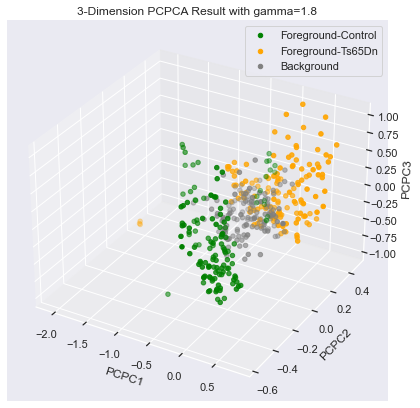

In [3]:
# Try 3D-Plot with seaborn package
pcpca = PCPCA(gamma=n / m * 0.9, n_components=3)  # Here actually gamma = 1
X_reduced, Y_reduced = pcpca.fit_transform(X_full, Y_full)

X_reduced_df = pd.DataFrame(X_reduced.T, columns=["PCPC1", "PCPC2","PCPC3"])
X_reduced_df["Genotype"] = X_df.Genotype.values

X_Control_df = X_reduced_df.iloc[:135,]
X_Ts65Dn_df = X_reduced_df.iloc[135:,]

Y_reduced_df = pd.DataFrame(Y_reduced.T, columns=["PCPC1", "PCPC2","PCPC3"])
Y_reduced_df["Genotype"] = ["Background" for _ in range(Y_reduced_df.shape[0])]

results_df = pd.concat([X_reduced_df, Y_reduced_df], axis=0)

# Drawing "Figure 11"

sns.set(style = "darkgrid")

fig = plt.figure(figsize=(42,7))
#plt.title("3-Dimension PCPCA Result with gamma=1.8")
ax = fig.add_subplot(111, projection = '3d')
#colors = ["green"]*135+["orange"]*135+["gray"]*135
#ax.scatter(results_df["PCPC1"],results_df["PCPC2"],results_df["PCPC3"],c=colors)
ax.scatter(X_Control_df["PCPC1"],X_Control_df["PCPC2"],X_Control_df["PCPC3"],c="green")
ax.scatter(X_Ts65Dn_df["PCPC1"],X_Ts65Dn_df["PCPC2"],X_Ts65Dn_df["PCPC3"],c="orange")
ax.scatter(Y_reduced_df["PCPC1"],Y_reduced_df["PCPC2"],Y_reduced_df["PCPC3"],c="gray")
ax.set_xlabel("PCPC1")
ax.set_ylabel("PCPC2")
ax.set_zlabel("PCPC3")
ax.set_title("3-Dimension PCPCA Result with gamma=1.8")
ax.legend(labels=["Foreground-Control","Foreground-Ts65Dn","Background"])

<AxesSubplot:xlabel='PCPC1', ylabel='PCPC2'>

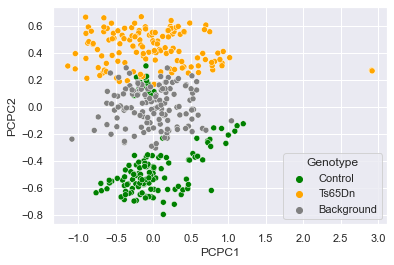

In [4]:
pcpca = PCPCA(gamma=n / m * 0.8, n_components=3)  # Here actually gamma = 1
X_reduced, Y_reduced = pcpca.fit_transform(X_full, Y_full)

X_reduced_df = pd.DataFrame(X_reduced.T, columns=["PCPC1", "PCPC2","PCPC3"])
X_reduced_df["Genotype"] = X_df.Genotype.values

Y_reduced_df = pd.DataFrame(Y_reduced.T, columns=["PCPC1", "PCPC2","PCPC3"])
Y_reduced_df["Genotype"] = ["Background" for _ in range(Y_reduced_df.shape[0])]

results_df = pd.concat([X_reduced_df, Y_reduced_df], axis=0)
sns.scatterplot(
    data=results_df,
    x="PCPC1",
    y="PCPC2",
    hue="Genotype",
    palette=["green", "orange", "gray"],
)

<AxesSubplot:xlabel='PCPC1', ylabel='PCPC2'>

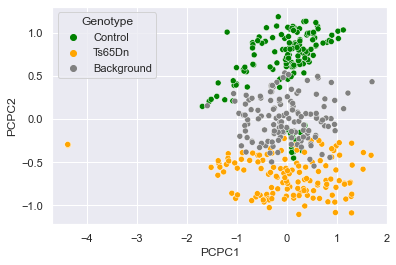

In [5]:
pcpca = PCPCA(gamma=n / m * 0.5, n_components=2)  # Here actually gamma = 1
X_reduced, Y_reduced = pcpca.fit_transform(X_full, Y_full)

X_reduced_df = pd.DataFrame(X_reduced.T, columns=["PCPC1", "PCPC2"])
X_reduced_df["Genotype"] = X_df.Genotype.values

Y_reduced_df = pd.DataFrame(Y_reduced.T, columns=["PCPC1", "PCPC2"])
Y_reduced_df["Genotype"] = ["Background" for _ in range(Y_reduced_df.shape[0])]

results_df = pd.concat([X_reduced_df, Y_reduced_df], axis=0)
sns.scatterplot(
    data=results_df,
    x="PCPC1",
    y="PCPC2",
    hue="Genotype",
    palette=["green", "orange", "gray"],
)

Silhouette Score for PCPCA and CPCA

In [6]:
# Silhouette Score for CPCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

N_COMPONENTS = 2
gamma_range_cpca = list(np.linspace(0, 200, 40))

# CPCA
cluster_scores_cpca = []
cpca_gamma_plot_list = []

for gamma in gamma_range_cpca:
    cpca_model = CPCA(gamma=gamma, n_components=N_COMPONENTS)
    X_reduced, Y_reduced = cpca_model.fit_transform(X_full, Y_full)


    kmeans = KMeans(n_clusters=2, random_state=0).fit(X_reduced.T)

    cpca_gamma_plot_list.append(gamma)
    data_full = np.concatenate((X_reduced.T, Y_reduced.T))
    
    # Foreground-Control is coded as "0", Foreground-Ts65Dn is coded as "1"
    # Background is coded as "2"
    true_labels = ["0"]*135+["1"]*135+["2"]*135
    cluster_score = silhouette_score(X=data_full, labels=true_labels)
    print("gamma'={}, cluster score={}".format(gamma, cluster_score))
    cluster_scores_cpca.append(cluster_score)

gamma'=0.0, cluster score=-0.04750220108589465
gamma'=5.128205128205129, cluster score=0.26763570550920485
gamma'=10.256410256410257, cluster score=0.31701309535449473
gamma'=15.384615384615387, cluster score=0.32966100813426197
gamma'=20.512820512820515, cluster score=0.33373360615587255
gamma'=25.641025641025642, cluster score=0.3350390574561663
gamma'=30.769230769230774, cluster score=0.33544981278157726
gamma'=35.8974358974359, cluster score=0.3356557466428953
gamma'=41.02564102564103, cluster score=0.33593028865738406
gamma'=46.15384615384616, cluster score=0.3362938159250661
gamma'=51.282051282051285, cluster score=0.3367855240715359
gamma'=56.410256410256416, cluster score=0.3373820343968417
gamma'=61.53846153846155, cluster score=0.3380653718425832
gamma'=66.66666666666667, cluster score=0.33880662061511774
gamma'=71.7948717948718, cluster score=0.33960200827660386
gamma'=76.92307692307693, cluster score=0.3404535623156838
gamma'=82.05128205128206, cluster score=0.3413209891474

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


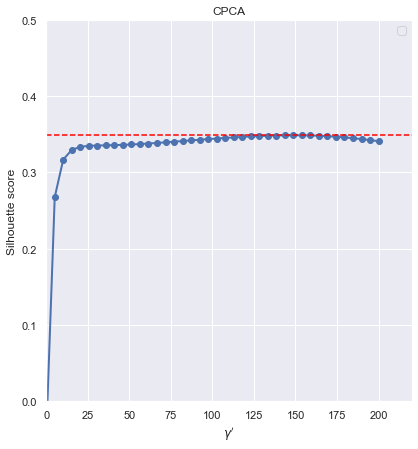

In [7]:
# Silhouette Score Plot for CPCA
plt.figure(figsize=(38, 7))
plt.subplot(151)
plt.plot(cpca_gamma_plot_list, cluster_scores_cpca, "-o", linewidth=2)
plt.title("CPCA")
plt.ylim([0, 0.5])
plt.xlim([0, cpca_gamma_plot_list[-1] + 20])
#plt.axvline(cpca_fail_gamma, color="black", linestyle="--")
plt.axhline(np.max(cluster_scores_cpca), color="red", linestyle="--")
plt.xlabel(r"$\gamma^\prime$")
plt.ylabel("Silhouette score")
plt.legend()

<AxesSubplot:title={'center':'CPCA, $\\gamma^\\prime$=150'}, xlabel='CPC1', ylabel='CPC2'>

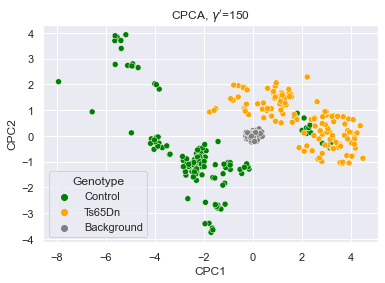

In [8]:
# CPCA 2D-Result Plot
cpca = CPCA(gamma=150, n_components=2)  # Here actually gamma = 1
X_reduced, Y_reduced = cpca.fit_transform(X_full, Y_full)

X_reduced_df = pd.DataFrame(X_reduced.T, columns=["CPC1", "CPC2"])
X_reduced_df["Genotype"] = X_df.Genotype.values

Y_reduced_df = pd.DataFrame(Y_reduced.T, columns=["CPC1", "CPC2"])
Y_reduced_df["Genotype"] = ["Background" for _ in range(Y_reduced_df.shape[0])]

results_df = pd.concat([X_reduced_df, Y_reduced_df], axis=0)

plt.title(r"CPCA, $\gamma^\prime$={}".format(150))
sns.scatterplot(
    data=results_df,
    x="CPC1",
    y="CPC2",
    hue="Genotype",
    palette=["green", "orange", "gray"],
)

In [9]:
# Silhouette Score for PCPCA
gamma_range_pcpca = list(np.linspace(0, 1.99, 40))
N_COMPONENTS = 2
cluster_scores_pcpca = []
pcpca_gamma_plot_list = []

for gamma in gamma_range_pcpca:
    pcpca_model = PCPCA(gamma=gamma, n_components=N_COMPONENTS)
    X_reduced, Y_reduced = pcpca_model.fit_transform(X_full, Y_full)

    #kmeans = KMeans(n_clusters=2, random_state=0).fit(X_reduced.T)
    data_full = np.concatenate((X_reduced.T, Y_reduced.T))

    pcpca_gamma_plot_list.append(gamma)

    # Foreground-Control is coded as "0", Foreground-Ts65Dn is coded as "1"
    # Background is coded as "2"
    true_labels = ["0"]*135+["1"]*135+["2"]*135
    cluster_score = silhouette_score(X=data_full, labels=true_labels)
    print("gamma'={}, cluster score={}".format(gamma, cluster_score))
    cluster_scores_pcpca.append(cluster_score)

gamma'=0.0, cluster score=-0.03070125125083437
gamma'=0.05102564102564103, cluster score=-0.025512942697852873
gamma'=0.10205128205128206, cluster score=-0.01654885831749393
gamma'=0.15307692307692308, cluster score=-0.0024449151189769682
gamma'=0.2041025641025641, cluster score=0.01672347879670271
gamma'=0.2551282051282051, cluster score=0.039341194838644296
gamma'=0.30615384615384617, cluster score=0.06248290276873292
gamma'=0.3571794871794872, cluster score=0.08326644631158171
gamma'=0.4082051282051282, cluster score=0.10045564053624742
gamma'=0.4592307692307692, cluster score=0.1141917844387549
gamma'=0.5102564102564102, cluster score=0.12511390664151037
gamma'=0.5612820512820513, cluster score=0.13372935544725711
gamma'=0.6123076923076923, cluster score=0.14043236479576568
gamma'=0.6633333333333333, cluster score=0.1457727496704685
gamma'=0.7143589743589744, cluster score=0.15015590425971584
gamma'=0.7653846153846154, cluster score=0.15374835797302036
gamma'=0.8164102564102564, cl

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


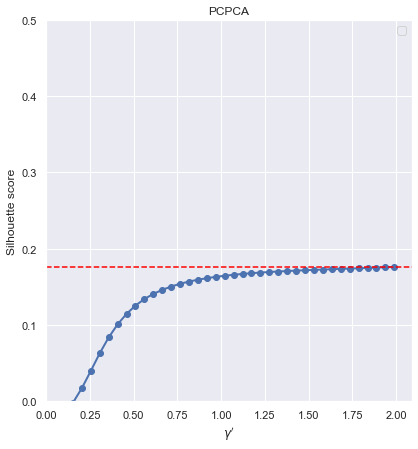

In [10]:
plt.figure(figsize=(38, 7))
plt.xlabel(r"$\gamma^\prime$")
plt.ylabel("Silhouette score")
plt.legend()
plt.subplot(152)
plt.plot(pcpca_gamma_plot_list, cluster_scores_pcpca, "-o", linewidth=2)
plt.title("PCPCA")
plt.ylim([0, 0.5])
plt.xlim([0, pcpca_gamma_plot_list[-1] + 0.1])
#plt.axvline(pcpca_fail_gamma, color="black", linestyle="--")
plt.axhline(np.max(cluster_scores_pcpca), color="red", linestyle="--")
#plt.axhline(clvm_cluster_score, color="blue", linestyle="--", label="CLVM")
plt.xlabel(r"$\gamma^\prime$")
plt.ylabel("Silhouette score")
plt.legend()

<AxesSubplot: title={'center': 'PCPCA, $\\gamma^\\prime$=1.99'}, xlabel='PCPC1', ylabel='PCPC2'>

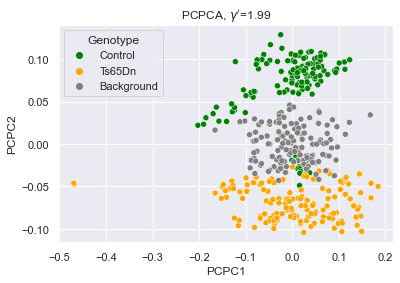

In [17]:
# PCPCA 2D-Result Plot
pcpca = PCPCA(gamma=1.99, n_components=2)  # Here actually gamma = 1
X_reduced, Y_reduced = pcpca.fit_transform(X_full, Y_full)

X_reduced_df = pd.DataFrame(X_reduced.T, columns=["PCPC1", "PCPC2"])
X_reduced_df["Genotype"] = X_df.Genotype.values

Y_reduced_df = pd.DataFrame(Y_reduced.T, columns=["PCPC1", "PCPC2"])
Y_reduced_df["Genotype"] = ["Background" for _ in range(Y_reduced_df.shape[0])]

results_df = pd.concat([X_reduced_df, Y_reduced_df], axis=0)

plt.title(r"PCPCA, $\gamma^\prime$={}".format(1.99))
sns.scatterplot(
    data=results_df,
    x="PCPC1",
    y="PCPC2",
    hue="Genotype",
    palette=["green", "orange", "gray"],
)